<a href="https://colab.research.google.com/github/pe8sutd/Colab_DSL_Practice25/blob/main/Simulation/simT03_CmodA7_UART_ADC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
print("[INFO]: Init Verilog Environment")
!pip install git+https://github.com/pe8sutd/eda4u &> /dev/null
!git clone https://github.com/pe8sutd/eda4u &> /dev/null
%load_ext plugin

[INFO]: Init Verilog Environment


# Drv_MCP3202

## Description:
 * This Verilog module implements an SPI interface for the MCP3202 Analog-to-Digital Converter (ADC).
 * It manages the communication process through a finite state machine (FSM) to read analog data and convert it to a digital format.
## Port
### Inputs:
 * - rstn: Active low reset signal.
 * - clk: Clock signal.
 * - ap_ready: Signal indicating the application is ready for data processing.
 * - mode: 2-bit input to select the ADC channel and configuration.
 *          localparam  SINGLE_CHAN0   = 2'b10; - CHANNEL 0;
 *          localparam  SINGLE_CHAN1   = 2'b11; - CHANNEL 1;
 *          localparam  DIFFER_CHAN01  = 2'b00;  - DIFFERENTIAL CHANNEL 01
 *          localparam  DIFFER_CHAN10  = 2'b01;  - DIFFERENTIAL CHANNEL 10
 * - port_din: Serial data input from the ADC.

### Outputs:
 * - ap_vaild: Signal that indicates valid data is available.
 * - data: 12-bit output holding the ADC conversion result.
 * - port_dout: Serial data output to the ADC.
 * - port_clk: Clock signal for the ADC.
 * - port_cs: Chip select signal for the ADC, active low.

## Functionality:
 * - The module configures the ADC based on the mode input.
 * - It uses an FSM to control the SPI communication process, including sending control bits, reading the ADC data, and signaling when new data is available.
 * - The ADC conversion result is made available as a 12-bit output.
 * - The module ensures synchronization with the external ADC device through careful management of clock and control signals.

 ## Implementation Details:
 * - The Data_Transmit wire is used to send control signals to the ADC.
 * - The Data_Receive register captures the ADC output.
 * - The FSM transitions through several states (IDLE, WRITE, READ, STOP) to manage the entire data transfer process.
 * - The cnter_writ and cnter_read registers are used to track progress through the transmit and receive phases, respectively.



 ## FSM Status Graph

![SPI_FSM_Status](https://github.com/pe8sutd/Colab_DSL_Practice25/blob/main/figure/T03_FSM_SPI.png?raw=1)

In [2]:
%%verilog

module drv_mcp3202(
    input rstn,
    input clk,
    input   ap_ready,
    output  reg ap_vaild,
    input   [1:0] mode,
    output  [11:0] data,

    input   port_din,
    output  reg port_dout,
    output  port_clk,
    output  reg port_cs
);

wire    [3:0]      Data_Transmit; // 4 bits CONTROL;
reg     [12:0]     Data_Receive;  // 1 bit NULL + 12 bits DATA;

assign Data_Transmit[3]    = 1'b1;
assign Data_Transmit[0]    = 1'b1;
assign Data_Transmit[2:1] = mode;

reg [1:0]   fsm_statu,fsm_next;
localparam FSM_IDLE = 2'b00;
localparam FSM_WRIT = 2'b10;
localparam FSM_READ = 2'b11;
localparam FSM_STOP = 2'b01;

reg [1:0] cnter_writ;
reg [3:0] cnter_read;

//FSM statu transfer;
always @(posedge clk, negedge rstn) begin
    if (!rstn)  fsm_statu <= FSM_IDLE;
    else        fsm_statu <= fsm_next;
end

//FSM Transfer Condition;
always @(*)begin
    if(!rstn) fsm_next <= FSM_IDLE;
    else begin
        case (fsm_statu)
            FSM_IDLE : fsm_next <= (ap_ready)? FSM_WRIT : FSM_IDLE;
            FSM_WRIT : fsm_next <= (2'd0 == cnter_writ)? FSM_READ : FSM_WRIT;
            FSM_READ : fsm_next <= (2'd0 == cnter_read)? FSM_STOP : FSM_READ;
            FSM_STOP : fsm_next <= (!ap_ready)? FSM_STOP : FSM_IDLE;
            default  : fsm_next <= FSM_IDLE;
        endcase
    end
end

//FSM Output - SPI Write Data
always @(negedge rstn,negedge clk)begin
    if (!rstn) begin
        cnter_writ  <= 2'd3;
        port_dout   <= 1'b1;
        port_cs     <= 1'b1;
    end else begin
        case (fsm_statu)
            FSM_IDLE : begin
                cnter_writ  <= 2'd3;
                port_dout   <= 1'b1;
                port_cs     <= 1'b1;
            end
            FSM_WRIT : begin
                port_cs     <= 1'b0;
                port_dout   <= Data_Transmit[cnter_writ];
                cnter_writ  <= cnter_writ - 1'b1;
            end
            FSM_READ : begin
                port_cs     <= 1'b0;
                port_dout   <= 1'b1;
            end
            FSM_STOP : port_cs     <= 1'b1;
            default  : ;
        endcase
    end
end

//FSM Output - SPI Read  Data
always @(negedge rstn,posedge clk)begin
    if (!rstn) begin
        cnter_read  <= 4'd13;
        Data_Receive <= 13'h00;
        ap_vaild = 1'b0;
    end else begin
        case (fsm_statu)
            FSM_IDLE : begin
                ap_vaild = 1'b0;
                cnter_read  <= 4'd13;
            end
            FSM_WRIT : begin
                Data_Receive <= 13'h00;
            end
            FSM_READ : begin
                cnter_read <= cnter_read - 1'b1;
                Data_Receive[cnter_read] <= port_din;
            end
            FSM_STOP : ap_vaild = 1'b1;
            default  : ;
        endcase
    end
end

assign port_clk = clk | port_cs;
assign data = Data_Receive[11:0];

endmodule

module drv_mcp3202_tb();

reg     rstn;
reg     clk;
reg     ap_ready;
wire    ap_vaild;
reg     [1:0] mode;
wire    [11:0] data;
reg     port_din;
wire    port_dout;
wire    port_clk;
wire    port_cs;
reg     CLK1Hz;

drv_mcp3202 drv_mcp3202_dut(rstn,clk,ap_ready,ap_vaild,mode,data,port_din,port_dout,port_clk,port_cs);

always #2  clk = ~ clk;

    // Test stimulus
    initial begin
        $dumpfile("drv_mcp3202_tb.vcd");
        $dumpvars;
    end

integer index;
initial begin
    rstn = 0;
    clk = 0;
    ap_ready = 0;
    mode = 2'b00;
    port_din = 1'b0;
    CLK1Hz = 1'b0;
    #3 rstn = 1;
    #4 ap_ready = 1;
    #20 ; //Wait Write 40 unit time;
    for (index = 0; index < 13; index = index + 1) #10 port_din = ($random%2);

    #4 ap_ready = 1;
    #20 ; //Wait Write 40 unit time;
    for (index = 0; index < 13; index = index + 1) #10 port_din = ($random%2);
    #5 $stop;
    $dumpoff;
    #10 $finish;
end



endmodule

Installing. Please wait... done!
VCD info: dumpfile drv_mcp3202_tb.vcd opened for output.
** VVP Stop(0) **
** Flushing output streams.
** Current simulation time is 316 ticks.
> ** Continue **



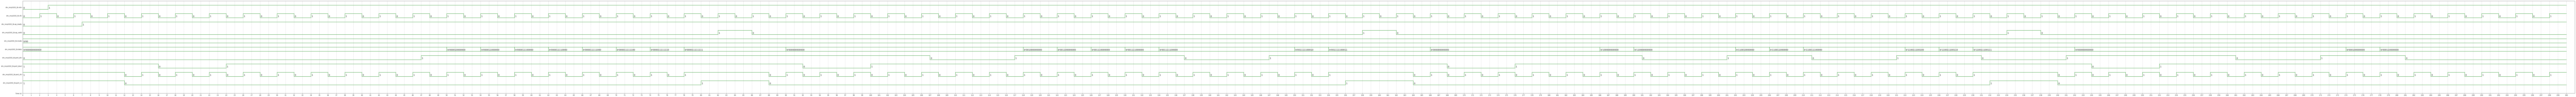

In [3]:
%%waveform drv_mcp3202_tb.vcd

sign_list = ["drv_mcp3202_tb.rstn","drv_mcp3202_tb.clk","drv_mcp3202_tb.ap_ready","drv_mcp3202_tb.ap_vaild","drv_mcp3202_tb.mode","drv_mcp3202_tb.data","drv_mcp3202_tb.port_din","drv_mcp3202_tb.port_dout","drv_mcp3202_tb.port_clk","drv_mcp3202_tb.port_cs"]

time_begin = 0
time_end = 300
base = 'bin' # bin, dec, dec2, hex, octal

# UART Tx with Parity Check


## Description
Implements a UART transmitter with optional parity bit functionality. This module encodes and transmits data over a serial line using the UART protocol. It supports transmitting data with start, stop, and optional parity bits, and signals the completion of transmission.

## Port
### Inputs:
* **clk**: System clock signal for synchronizing the transmission process (Baud Rate).
* **ap_rstn**: Asynchronous, active low reset signal to initialize or reset the module's internal states.
* **ap_ready**: Input signal indicating readiness to start data transmission. When high, transmission begins.
* **pairty**: Input signal to enable (when high) or disable (when low) parity bit generation and transmission.
* **data**: 8-bit data input to be transmitted over UART.

### Outputs:
* **ap_vaild**: Output signal that indicates the completion of a data transmission cycle.
* **tx**: Serial output transmitting the encoded data along with start, stop, and optional parity bits.

## Local Parameters:
* **FSM_IDLE**, **FSM_STAR**, **FSM_TRSF**, **FSM_PARI**, **FSM_STOP**: Represent the states of the finite state machine (FSM) controlling the UART transmission process, from idle, through start bit, data transmission, optional parity bit, and stop bit.

## Internal Registers:
* **fsm_statu**: Holds the current state of the FSM.
* **fsm_next**: Determines the next state of the FSM based on the current state and input signals.
* **cnter**: Counter used during the data transmission state to index through the data bits.

## Behavioral Blocks:
1. **fsm statu transfer**: Sequential logic block that updates the current state of the FSM on each positive clock edge or on negative edge of ap_rstn. Resets to FSM_IDLE on reset.
2. **fsm conditional transfer**: Combinatorial logic block that determines the next state of the FSM based on current conditions like ap_ready signal, counter value, and parity configuration.
3. **fsm - output**: Sequential logic block that performs actions based on the current FSM state, including setting the tx output according to the data bits, generating a parity bit if enabled, and indicating the end of transmission through ap_vaild signal. Also handles the initialization of internal signals on reset.


## FSM Status Graph


![UART_FSM](https://github.com/pe8sutd/Colab_DSL_Practice/blob/main/figure/T03_FSM_UART.png?raw=1)

In [4]:
%%verilog

//--my 2 inputs and gate--//
module drv_uart_tx(
    input   clk,
    input   ap_rstn,
    input   ap_ready,
    output  reg ap_vaild,
    output  reg tx,
    input   pairty,
    input  [7:0] data
);

localparam  FSM_IDLE = 3'b000,
            FSM_STAR = 3'b001,
            FSM_TRSF = 3'b010,
            FSM_PARI = 3'b011,
            FSM_STOP = 3'b100;

reg [2:0] fsm_statu;
reg [2:0] fsm_next;
reg [2:0] cnter;

//fsm statu transfer;
always @(posedge clk, negedge ap_rstn) begin
    if (!ap_rstn)begin
        fsm_statu <= FSM_IDLE;
    end else begin
        fsm_statu <= fsm_next;
    end
end

//fsm conditional transfer;
always @(*)begin
    if(!ap_rstn)begin
        fsm_next <= FSM_IDLE;
    end else begin
        case(fsm_statu)
            FSM_IDLE:begin
                fsm_next <= (ap_ready) ? FSM_STAR : FSM_IDLE;
            end
            FSM_STAR: fsm_next <= FSM_TRSF;
            FSM_TRSF:begin
                fsm_next <= (cnter == 3'h7) ? (pairty?FSM_PARI:FSM_STOP) : FSM_TRSF;
            end
            FSM_PARI: fsm_next <= FSM_STOP;
            FSM_STOP:begin
                fsm_next <= (!ap_ready) ? FSM_IDLE : FSM_STOP;
            end
            default: fsm_next <= FSM_IDLE;
        endcase
    end
end

//fsm - output
always @(posedge clk, negedge ap_rstn)begin
    if(!ap_rstn)begin
        ap_vaild <= 1'b0;
        tx <= 1'b1;
        cnter <= 3'h0;
    end else begin
        case (fsm_statu)
            FSM_IDLE: begin
                tx <= 1'b1;
                ap_vaild <= 1'b0;
            end
            FSM_STAR: begin
                tx <= 1'b0;
                cnter <= 3'h0;
            end
            FSM_TRSF: begin
                tx <= data[cnter];
                cnter <= cnter + 1'b1;
            end
            FSM_PARI: tx <= (^data); //Parity Check - ODD Check;
            FSM_STOP: begin
                tx <= 1'b1;         //Stop Bit;
                ap_vaild <= 1'b1;
            end
        endcase
    end
end

endmodule
//-----//

//-----//
module tb_uart_tx();

reg         dut_clk        ;
reg         dut_ap_rstn    ;
reg         dut_ap_ready  ;
reg         dut_pairty    ;
reg   [7:0] dut_data      ;

wire  dut_ap_vaild    ;
wire  dut_tx          ;

drv_uart_tx uart_tx_dut(
    .clk(dut_clk),
    .ap_rstn(dut_ap_rstn),
    .ap_ready(dut_ap_ready),
    .ap_vaild(dut_ap_vaild),
    .tx(dut_tx),
    .pairty(dut_pairty),
    .data(dut_data)
);


    // Test stimulus
    initial begin
        $dumpfile("tb_uart_tx.vcd");
        $dumpvars;
    end

    //Generate Clock;
    initial begin
        dut_clk <= 1'b0;
        forever begin
          #1 dut_clk <= ~dut_clk;
         end
    end

    initial begin
       // Initialize all input signal;
       dut_ap_rstn <= 1'b0;
       dut_ap_ready <= 1'b0;
       dut_pairty <= 1'b0;
       dut_data <= 8'b01010111; //ASCII Code
       #2 dut_ap_rstn <= 1'b1;

       // Start Uart Tx Event
       #4 dut_ap_ready <= 1'b1;
       // Finish Uart Tx;
       #26 dut_ap_ready <= 1'b0;

       // Start Another Uart Tx Event
        #4 dut_ap_ready <= 1'b1;
        dut_data <= 8'b0000_1110;
        // Finish Uart Tx;
        #26 dut_ap_ready <= 1'b0;
        #10         $dumpoff;
                    $finish();
    end

endmodule

VCD info: dumpfile tb_uart_tx.vcd opened for output.



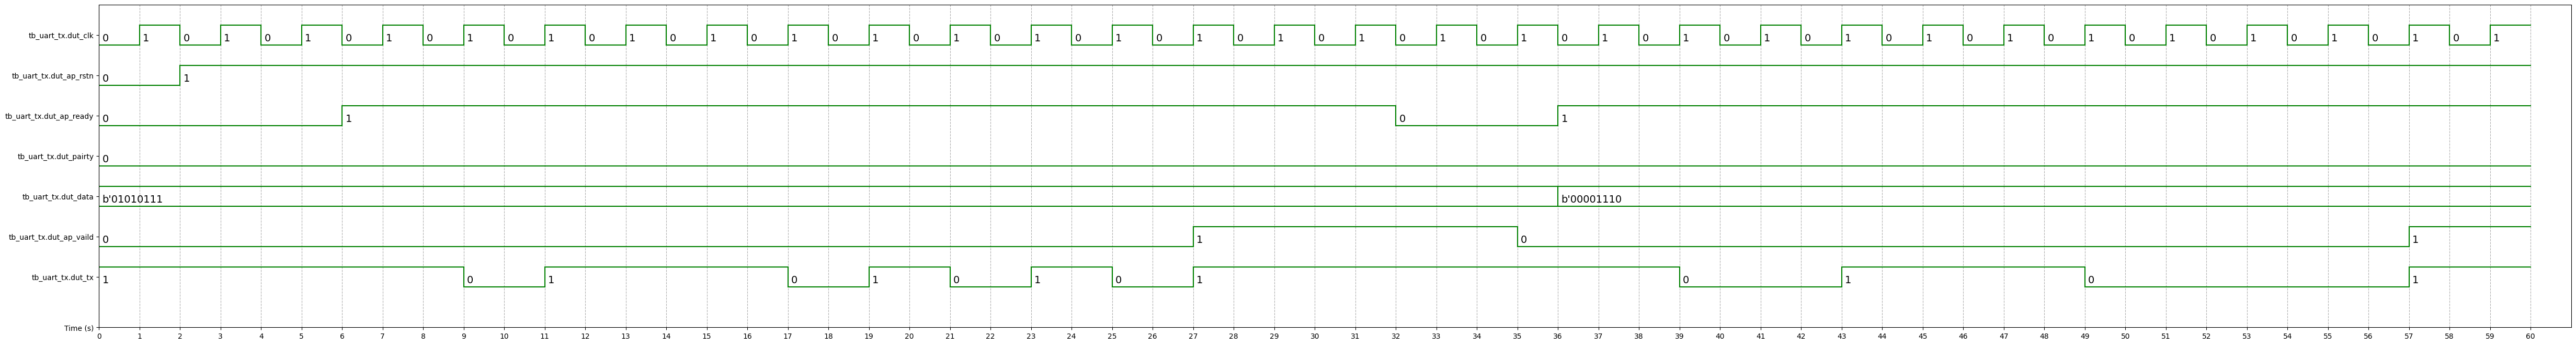

In [5]:
%%waveform tb_uart_tx.vcd

sign_list = ["tb_uart_tx.dut_clk","tb_uart_tx.dut_ap_rstn","tb_uart_tx.dut_ap_ready", "tb_uart_tx.dut_pairty", "tb_uart_tx.dut_data", "tb_uart_tx.dut_ap_vaild","tb_uart_tx.dut_tx"]

time_begin = 0
time_end = 60
base = 'bin' # bin, dec, dec2, hex, octal

#End